In [1]:
import hiro.eval_hiro as eval_hiro
from hiro.hiro import get_tensor
from torch.autograd import Variable
import torch
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

In [3]:
from parser import build_parser, get_parser_args

parser = build_parser()
args = get_parser_args(parser, ["--env_name", "AntMaze",  "--hiro_only", "--eval_only"])

In [4]:
args

Namespace(candidate_goals=10, ctrl_act_lr=0.0001, ctrl_batch_size=128, ctrl_buffer_size=200000.0, ctrl_crit_lr=0.001, ctrl_discount=0.95, ctrl_noise_sigma=1.0, ctrl_rew_scale=1.0, ctrl_rew_type='rig', ctrl_tau=0.005, discount=0.99, env_name='AntMaze', eval_freq=5000.0, eval_only=True, hiro_only=True, inner_dones=False, load=True, log_dir='./logs/', log_file='hiro', man_act_lr=0.0001, man_batch_size=128, man_buffer_size=200000.0, man_crit_lr=0.001, man_last_layer='fc', man_noise_sigma=1.0, man_rew_scale=0.1, man_tau=0.005, manager_propose_freq=10, max_timesteps=50000000.0, no_correction=False, noise_type='normal', random_params=False, rew_thresh=-0.0001, reward_type='dense', save_every=50000, save_models=False, seed=0, train_manager_freq=10)

In [5]:
env, controller_policy, manager_policy, calculate_controller_reward = eval_hiro.get_env_and_policy(args)

/home/greg/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


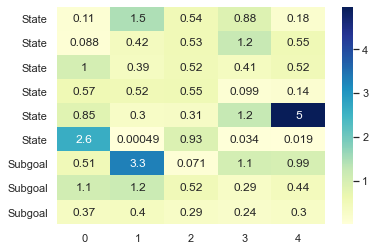

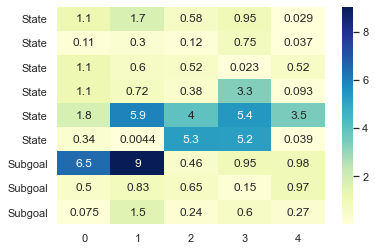

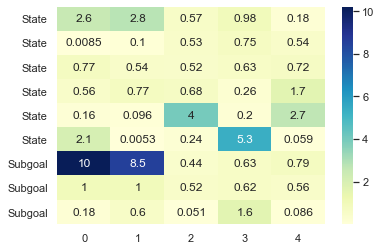

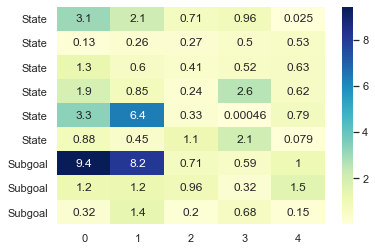

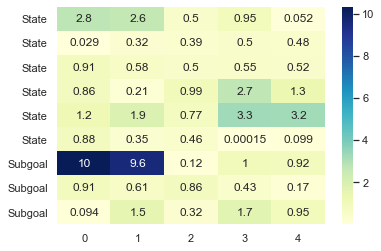

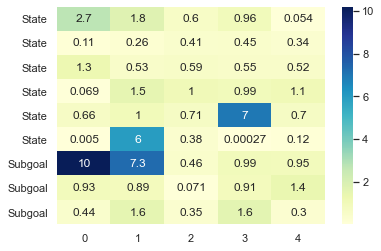

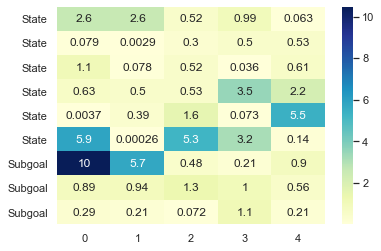

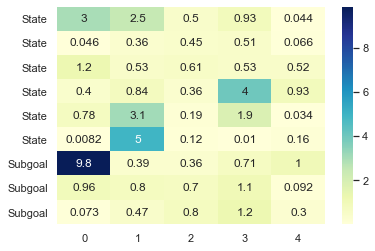

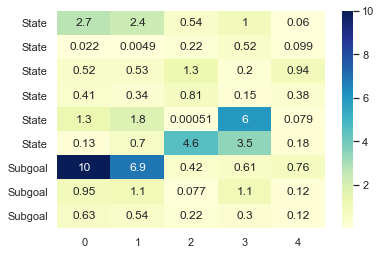

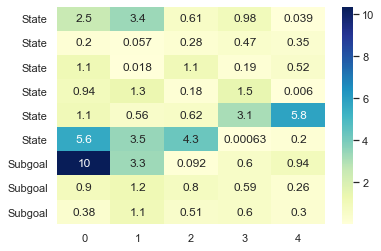

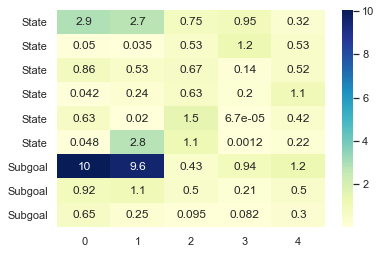

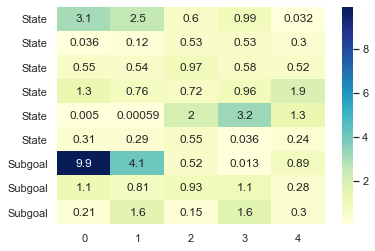

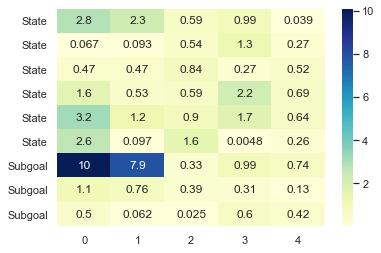

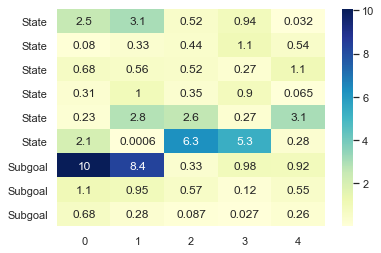

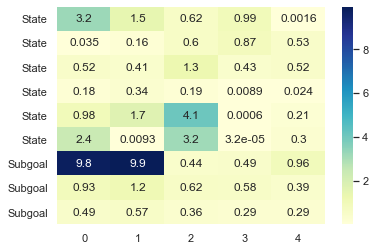

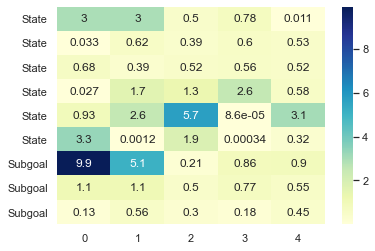

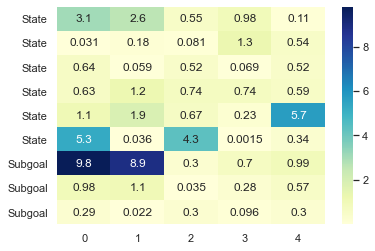

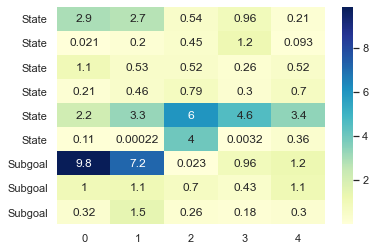

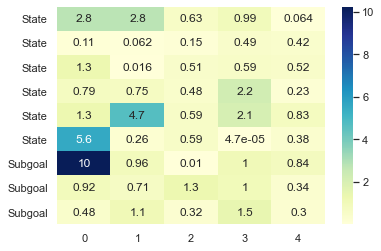

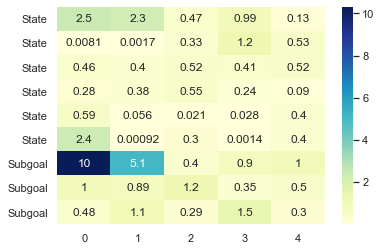

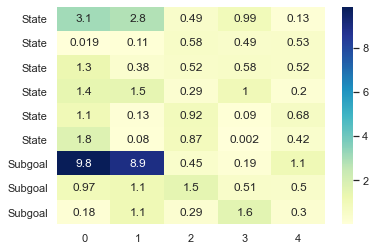

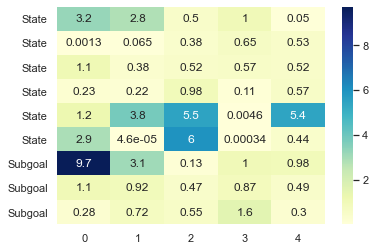

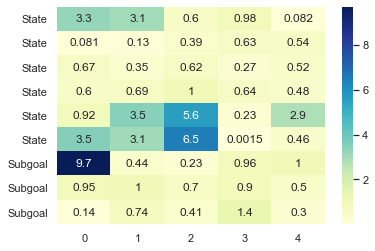

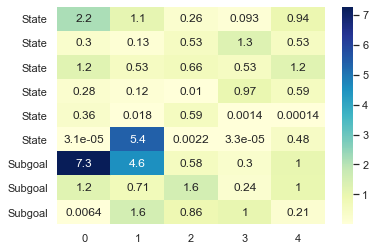

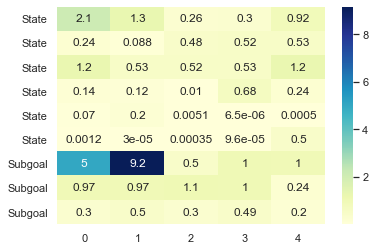

500 False


In [6]:
obs = env.reset()
env.evaluate = True
goal = obs['desired_goal']
state = obs['observation']


sns.set()

done = False
step_count = 0
grads = []
while not done:
    if step_count % args.manager_propose_freq == 0:
        subgoal = manager_policy.sample_goal(state, goal)

    step_count += 1
    
    state_tensor = Variable(get_tensor(state), requires_grad=True)
    subgoal_tensor = Variable(get_tensor(subgoal), requires_grad=True)

    action = controller_policy.select_action(state_tensor, subgoal_tensor, to_numpy=False, from_numpy=False, no_grad=False)
    
    # We can't back propagate with a vector, so we take the mean of all the actions and backpropagate from there
    # All elements of the action are considered equally important
    loss = action.mean()
    loss.backward()
    
    
    new_obs, reward, done, _ = env.step(action.detach().numpy())
    state_and_subgoal = torch.cat([state_tensor, subgoal_tensor], dim=1)
    state_and_subgoal_numpy = state_and_subgoal.abs().detach().numpy()
    grads.append(state_and_subgoal_numpy[0])
    
    if step_count % 20 == 0:
        # A variable matters if the gradient between the actions and that variable is high IN ABSOLUTE VALUE.
        # This is true because a large gradient means that changing the variable a bit will have large impact
        # on the actions. On the other
        yticklabels = ["State"] * 6 + ["Subgoal"] * 3
        plt.figure(figsize=(6, 4))
        sns.heatmap(state_and_subgoal_numpy.reshape(-1, 5), cmap="YlGnBu", yticklabels=yticklabels, annot=True)
        plt.show()
        
    # See if the environment goal was achieved
    goal_achieved = reward >= -env.distance_threshold
    if goal_achieved:
        done = True

    goal = new_obs['desired_goal']
    new_state = new_obs['observation']

    # Update subgoal in the controller (g' = s + g - s'). DOESN'T update the subgoal in the manager
    subgoal = controller_policy.subgoal_transition(state, subgoal, new_state)

    controller_reward = calculate_controller_reward(state, subgoal, new_state, args.ctrl_rew_scale)
    state = new_state

print(step_count, goal_achieved)

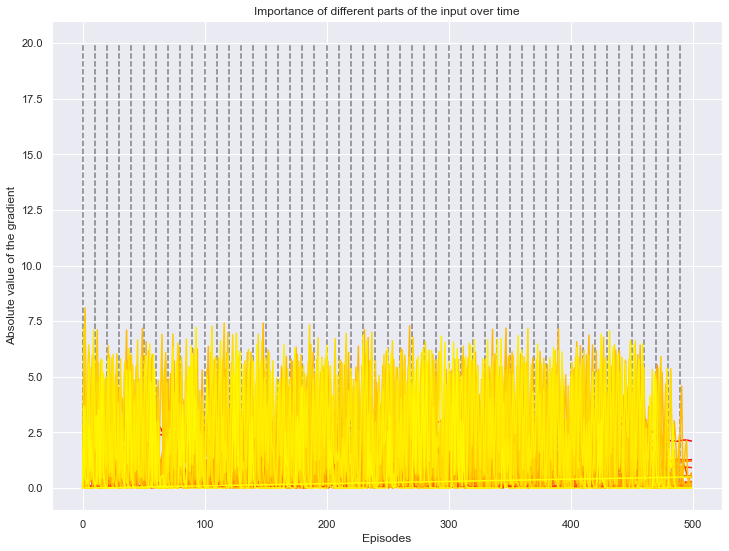

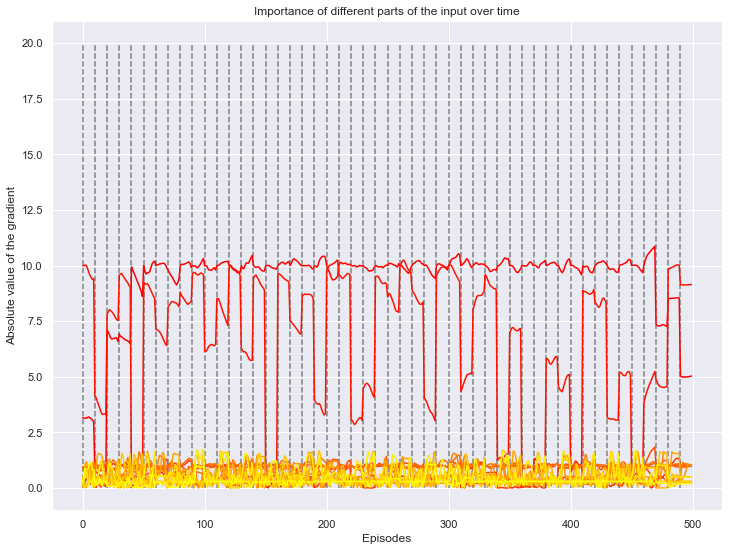

In [7]:

import matplotlib.cm as cm
grads = np.array(grads)
x = np.arange(len(grads))

labels = ["State: %d" % i for i in range(30)] + ["Subgoal: %d" % i for i in range(15)] 

color_states = cm.autumn(np.linspace(0,1,30))
color_subgoals = cm.autumn(np.linspace(0,1,15))

# Figure over state

plt.figure(figsize=(12, 9))
for c, i in zip(color_states, range(30)):
    plt.plot(x, grads[:, i], color=c)
    
for i in range(0, step_count, args.manager_propose_freq):
    plt.vlines(i, ymin=0, ymax=20, linestyles='dashed', color="grey")


plt.title("Importance of different parts of the input over time")
plt.xlabel("Episodes")
plt.ylabel("Absolute value of the gradient");
    
# Figure over subgoal
    
plt.figure(figsize=(12, 9))
for c, i in zip(color_subgoals, range(15)):
    plt.plot(x, grads[:, i + 30], color=c)

for i in range(0, step_count, args.manager_propose_freq):
    plt.vlines(i, ymin=0, ymax=20, linestyles='dashed', color="grey")

plt.title("Importance of different parts of the input over time")
plt.xlabel("Episodes")
plt.ylabel("Absolute value of the gradient");


In [8]:
grads.shape

(500, 45)

In [10]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367
